In [1]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from pathlib import Path
from matplotlib.ticker import MaxNLocator

sys.path.append("../helpers/")
from impresso_id import *

sns.set()

data_path = "data"

%load_ext autoreload
%autoreload 2

# Manually tagged tables
## Exploration

In [2]:
df = pd.read_parquet(os.path.join(data_path, "RB.parquet"))

In [3]:
print(f"The dataset contains {len(df)} articles labelled as stock tables.")
print(f"The dataset contains {len(df['pid'].unique())} pages.")
print(f"The dataset contains {len(df['meta_issue_id'].unique())} issues.")

The dataset contains 822 articles labelled as stock tables.
The dataset contains 488 pages.
The dataset contains 312 issues.


In [4]:
tagset = df['tag'].unique()
print(tagset)
journals = df['journal'].unique()
print(journals)

['stock' 'not a table' 'table' 'food prices']
['JDG' 'IMP' 'GDL']


In [5]:
tag_colors = {'stock': 'gold', 
              'food prices': 'green',
              'table': 'lightsteelblue',
              'not a table': 'magenta'}

journal_colors = {'JDG': 'gold', 
                  'IMP': 'blue', 
                  'GDL': 'green'}

### Class distribution

In [6]:
df_count_per_tag = df.groupby('tag').count()['pid'].sort_values()

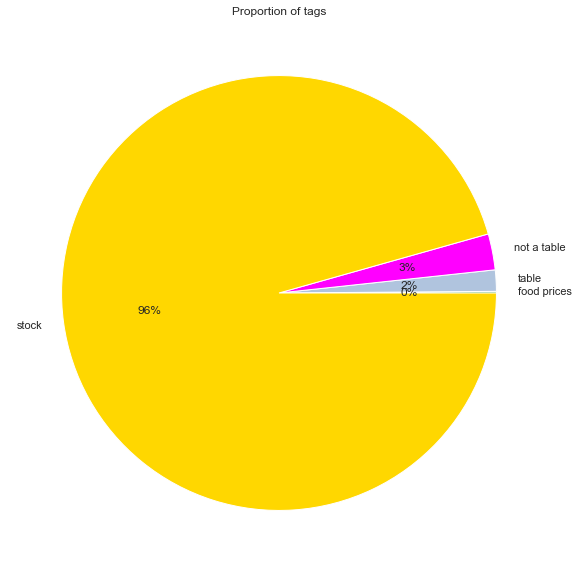

In [7]:
plt.figure(figsize=(10,10))
plt.pie(df_count_per_tag, labels=df_count_per_tag.index, 
        colors=[tag_colors[name] for name, _ in df_count_per_tag.iteritems()], 
        autopct='%1.0f%%')
plt.title("Proportion of tags")
plt.show()

### Tag distribution over time

In [8]:
df_per_year = df.groupby(['year', 'tag']).count().reset_index()
years = range(min(df['year']), max(df['year']) + 1)
df_years = pd.Series(0, index=years)

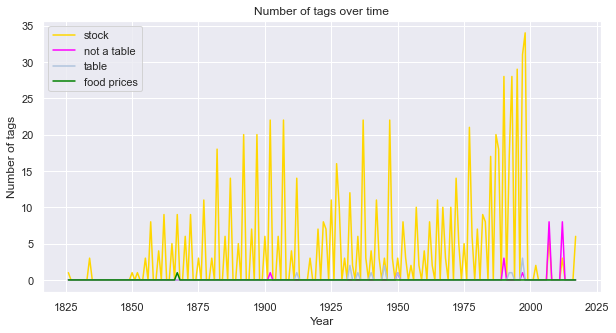

In [9]:
plt.figure(figsize=(10, 5))
for tag in tagset:
    df_tmp = df_per_year.loc[df_per_year['tag'] == tag, ['year', 'pid']].set_index('year')
    df_tmp = df_years.combine(df_tmp['pid'], lambda x, y: max(x, y))
    plt.plot(df_tmp.index, df_tmp.values, label=tag, color=tag_colors[tag])
plt.title("Number of tags over time")
plt.xlabel("Year")
plt.ylabel("Number of tags")
plt.legend()
plt.show()

### Tag distribution per journal

In [10]:
df_count_per_journal = df.groupby('journal').count()['pid'].sort_values()

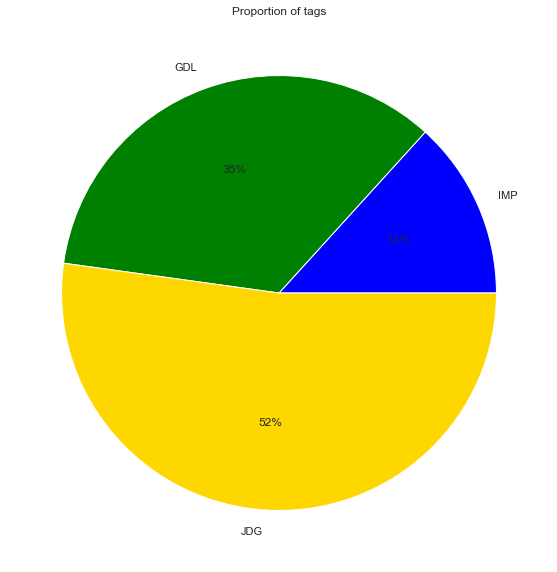

In [11]:
plt.figure(figsize=(10,10))
plt.pie(df_count_per_journal, labels=df_count_per_journal.index, 
        colors=[journal_colors[name] for name, _ in df_count_per_journal.iteritems()], 
        autopct='%1.0f%%')
plt.title("Proportion of tags")

plt.show()

In [12]:
df_journal_per_year = df.groupby(['year', 'journal']).count().reset_index()
years = range(min(df['year']), max(df['year']) + 1)
df_years = pd.Series(0, index=years)

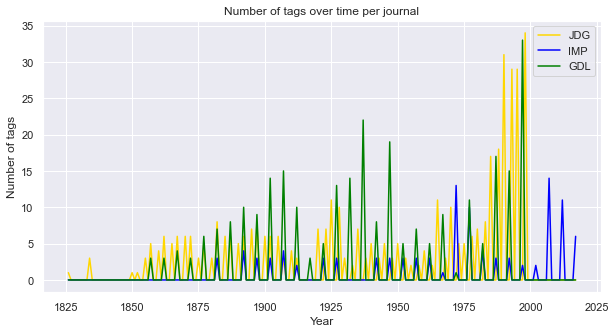

In [13]:
plt.figure(figsize=(10, 5))
for journal in journals:
    if journal in df_journal_per_year['journal'].unique():
        df_journal_tmp = df_journal_per_year.loc[df_journal_per_year['journal'] == journal, ['year', 'pid']].set_index('year')
        df_journal_tmp = df_years.combine(df_journal_tmp['pid'], lambda x, y: max(x, y))
        plt.plot(df_journal_tmp.index, df_journal_tmp.values, label=journal, color=journal_colors[journal])
plt.title("Number of tags over time per journal")
plt.xlabel("Year")
plt.ylabel("Number of tags")
plt.legend()
plt.show()

In [14]:
df_no_table = df[df['tag'] != 'not a table']

In [15]:
print(f"The dataset contains {len(df_no_table)} different tables.")
print(f"The dataset contains {len(df_no_table['pid'].unique())} different pages.")
print(f"The dataset contains {len(df_no_table['meta_issue_id'].unique())} different issues.")

The dataset contains 800 different tables.
The dataset contains 474 different pages.
The dataset contains 311 different issues.


In [16]:
pages_per_journal = Counter([get_journal(x) for x in df_no_table['pid'].unique()])
pages_per_journal = pd.DataFrame(pages_per_journal.values(), pages_per_journal.keys())
pages_per_journal = pages_per_journal.reset_index().rename({"index": "Journal", 0: "Count"}, axis=1)
pages_per_journal = pages_per_journal.sort_values("Journal").reset_index(drop=True)

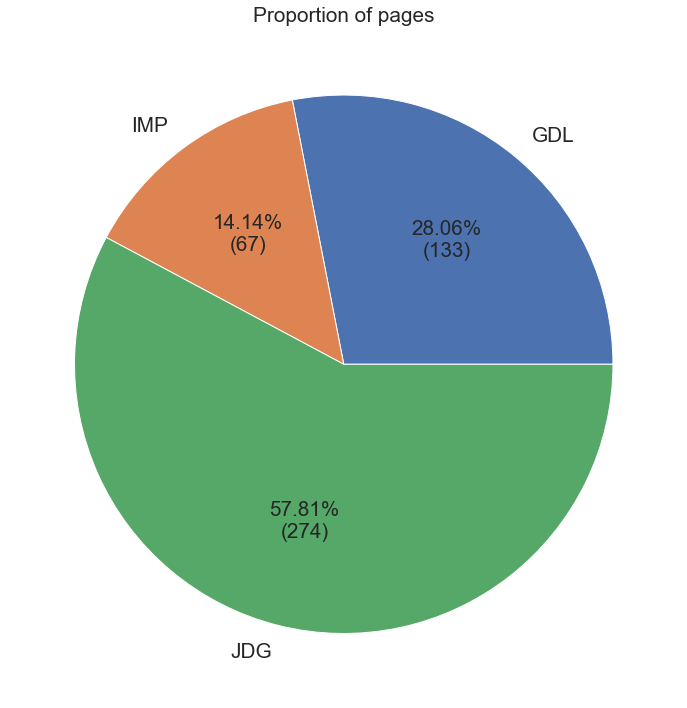

In [17]:
def my_fmt(x):
    return '{:.2f}%\n({:.0f})'.format(x, len(df_no_table.pid.unique())*x/100)

plt.figure(figsize=(10,10))
plt.pie(pages_per_journal['Count'], labels=pages_per_journal['Journal'], 
        colors=sns.color_palette(), 
        autopct=my_fmt, textprops={'fontsize': 'xx-large'})
plt.title("Proportion of pages", fontsize='xx-large')
plt.tight_layout()
plt.show()

/var/folders/cg/xntycr5n6mb07k869c_cv4lr0000gn/T/ipykernel_22781/3473074552.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  bar1 = sns.histplot(x='year', hue='journal', data=df_no_table.groupby('pid').max(), multiple='stack', bins=len(years))


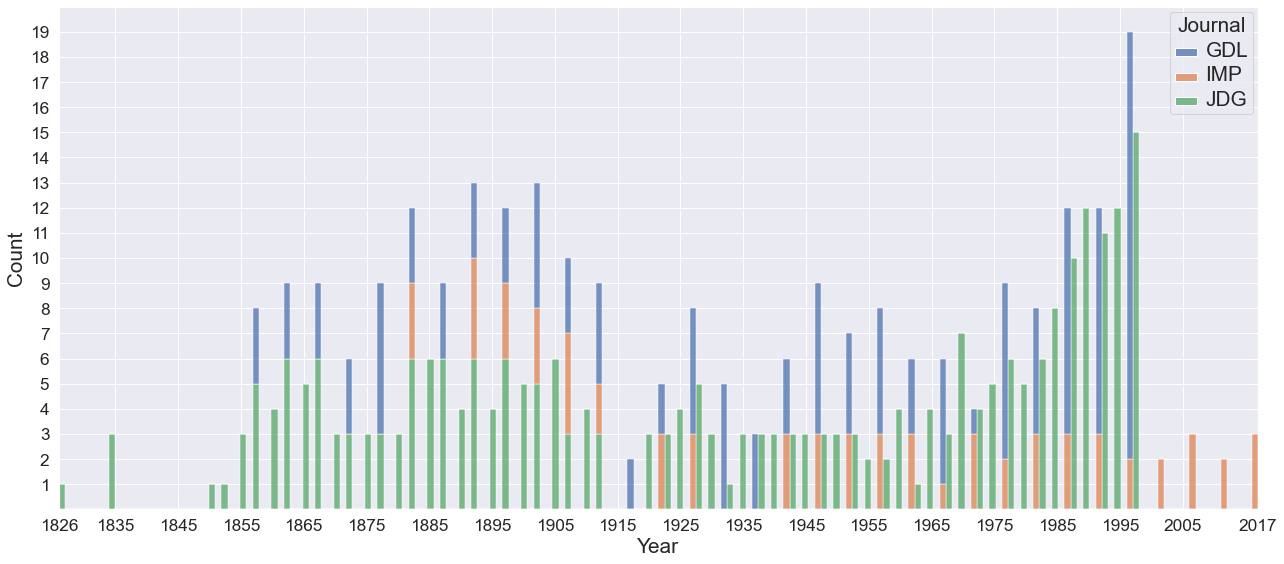

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
min_year = df_no_table['year'].min()
max_year = df_no_table['year'].max()
years = range(min_year, max_year + 1)
bar1 = sns.histplot(x='year', hue='journal', data=df_no_table.groupby('pid').max(), multiple='stack', bins=len(years))

years = [years[0]] + list(range(1835, 2011, 10)) + [years[-1]]
ax.axes.xaxis.set_ticks(years)
count = range(1, 20)
ax.axes.yaxis.set_ticks(count)
ax.tick_params(axis='both', which='major', labelsize='x-large')

ax.margins(x=0, y=0)
plt.ylim([0,20])
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.setp(bar1.get_legend().get_title(), fontsize='xx-large', text='Journal') 
plt.setp(bar1.get_legend().get_texts(), fontsize='xx-large')
plt.tight_layout()
plt.show()

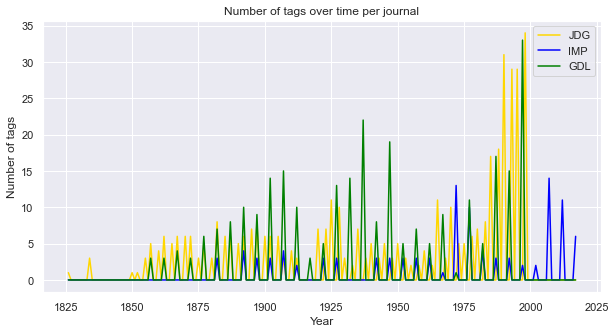

In [19]:
plt.figure(figsize=(10, 5))
for journal in journals:
    if journal in df_journal_per_year['journal'].unique():
        df_journal_tmp = df_journal_per_year.loc[df_journal_per_year['journal'] == journal, ['year', 'pid']].set_index('year')
        df_journal_tmp = df_years.combine(df_journal_tmp['pid'], lambda x, y: max(x, y))
        plt.plot(df_journal_tmp.index, df_journal_tmp.values, label=journal, color=journal_colors[journal])
plt.title("Number of tags over time per journal")
plt.xlabel("Year")
plt.ylabel("Number of tags")
plt.legend()
plt.show()

### Tag distribution per journal

In [20]:
df_journal_tag_per_year = df.groupby(['year', 'tag', 'journal']).count().reset_index()
years = range(min(df['year']), max(df['year']) + 1)
df_years = pd.Series(0, index=years)

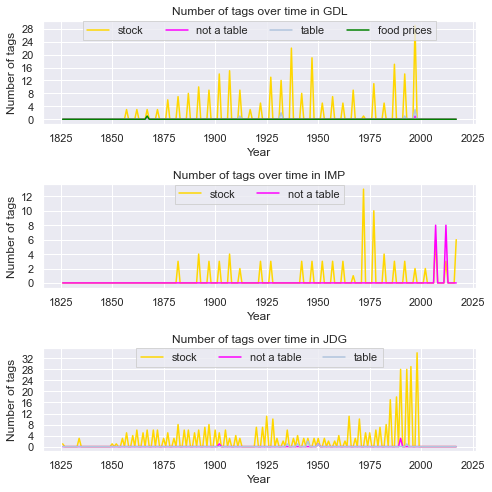

In [21]:
num_journals = len(df_journal_tag_per_year['journal'].unique())

plt.figure(figsize=(7,7))

i = 1
for journal in sorted(journals):
    if journal in df_journal_tag_per_year['journal'].unique():
        ax = plt.subplot(3, 1, i)
        for tag in tagset:
            df_tmp = df_journal_tag_per_year.loc[(df_journal_tag_per_year['tag'] == tag) & (df_journal_tag_per_year['journal'] == journal), ['year', 'pid']].set_index('year')
            df_tmp = df_years.combine(df_tmp['pid'], lambda x, y: max(x, y))
            if len(df_tmp[df_tmp > 0]) > 0:
                plt.plot(df_tmp.index, df_tmp.values, label=tag, color=tag_colors[tag])
                
        plt.title(f"Number of tags over time in {journal}")
        plt.xlabel("Year")
        plt.ylabel("Number of tags")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=False, shadow=False)
        i += 1

plt.tight_layout()
plt.show()